In [1]:
#!pip install -e ../Maccabee > /dev/null

In [2]:
from maccabee.constants import Constants
from maccabee.data_sources.data_source_builders import build_random_normal_datasource
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid
from maccabee.modeling.models import LinearRegressionCausalModel

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [7]:
axes_and_metrics = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

In [24]:
%%time

Constants.DGPSampling.ADJUST_ALIGNMENT = True
Constants.DGPSampling.NORMALIZE_SAMPLED_OUTCOME_FUNCTION = True
Constants.DGPSampling.CENTER_SAMPLED_OUTCOME_FUNCTION = True
Constants.DGPSampling.NORMALIZE_SAMPLED_TREATMENT_FUNCTION = True

normal_data_source = build_random_normal_datasource(
    n_covars=5,
    n_observations=250)

LOW, MEDIUM, HIGH = Constants.AxisLevels.LEVELS

axis_results = {}
for axis, metrics in axes_and_metrics.items():
    print(f"Running Axis {axis}")
    
    param_grid = {
        axis: [HIGH, MEDIUM, LOW]
    }
    
    metric_spec = {
        axis: metrics
    }
    
    result = benchmark_model_using_sampled_dgp_grid(
        model_class=LinearRegressionCausalModel,
        estimand=Constants.Model.ATE_ESTIMAND,
        data_source=normal_data_source,
        dgp_param_grid=param_grid,
        data_analysis_mode=True,
        data_metrics_spec=metric_spec,
        num_dgp_samples=16,
        num_sampling_runs_per_dgp=1,
        num_samples_from_dgp=400,
        n_jobs=8)
    
    axis_results[axis] = result

Running Axis OUTCOME_NONLINEARITY
Running Axis TREATMENT_NONLINEARITY
Running Axis PERCENT_TREATED
Running Axis BALANCE
Running Axis ALIGNMENT
Running Axis TE_HETEROGENEITY
CPU times: user 14.3 s, sys: 9.75 s, total: 24 s
Wall time: 17min 45s


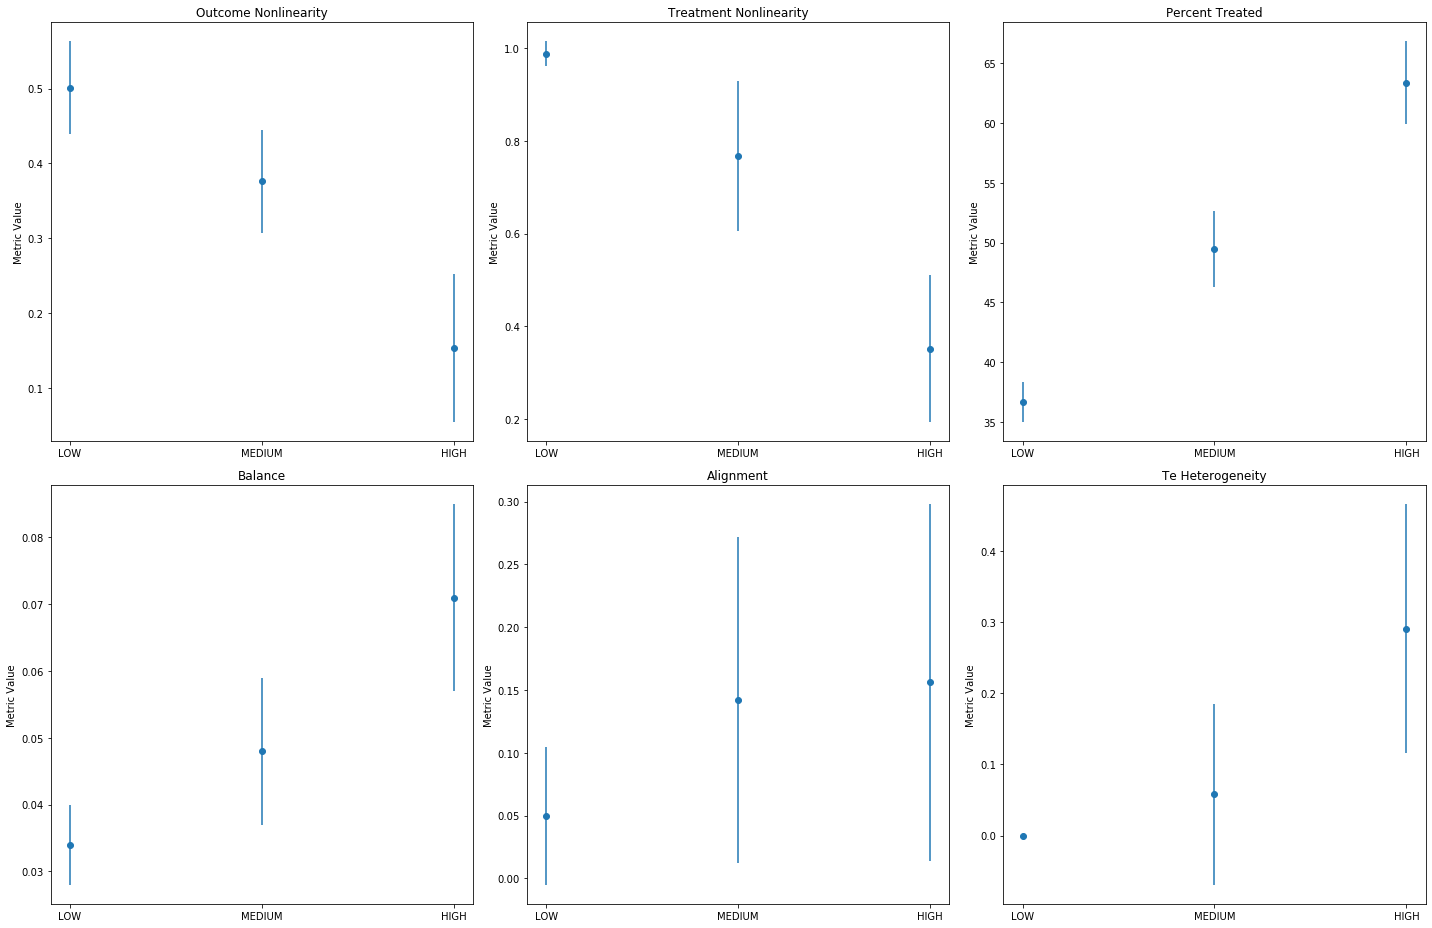

In [26]:
n_plots = sum(map(len, axes_and_metrics.values()))
n_cols = 3
n_rows = math.ceil(n_plots/n_cols)


fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 13))
plt.setp(axes, xticks=[0, 1, 2], xticklabels=[LOW, MEDIUM, HIGH])

plot_index = 0

for axis, metrics in axes_and_metrics.items():
    results_df = pd.DataFrame(axis_results[axis])
    param = results_df.columns.values[0]
    
    for metric in metrics:
        plot_index += 1
        metric_means = []
        metric_stds = []
        axis_metric_key = f"{axis} {metric}"
        for index, level in enumerate(Constants.AxisLevels.LEVELS):
            mean = float(results_df[results_df[param] == level][f"{axis} {metric}"])
            std = float(results_df[results_df[param] == level][axis_metric_key +  " (std)"])
            metric_means.append(mean)
            metric_stds.append(std)
        
        ax_index = np.unravel_index(plot_index-1, (n_rows, n_cols))
        ax = axes[ax_index]
        ax.errorbar(
            np.arange(len(metric_means)), metric_means, yerr=metric_stds,
            ls='None', marker='o')
#         ax = plt.gca()
#         ax.xaxis.set_ticks(np.arange(len(metric_means)))
#         ax.xaxis.set_ticklabels([LOW, MEDIUM, HIGH], rotation=0)
        
        axis_name = " ".join(axis.lower().split("_")).title()
        ax.set_title(axis_name)
        ax.set_ylabel("Metric Value")

fig.tight_layout()
plt.show()